In [13]:
%load_ext autoreload
%autoreload 1
%aimport ecg_get_data
%aimport Models
%aimport train_test_validat
%aimport self_attention
%aimport ECGplot
%aimport Net
%aimport select_dataset
%aimport relat_abs_Net
import select_dataset
import relat_abs_Net

import Models 
import Net
import ConmparisonModel.inception_resnet_v2
import ConmparisonModel.se_inception_resnet_v2
from train_test_validat import *
from self_attention import *
import  ecg_get_data 
import matplotlib.pyplot as plt
import ecg_plot

import torch
import torch.utils.data as Data
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import random

import time
import os
import gc

# random_seed = 2
# torch.manual_seed(random_seed)    # reproducible
# torch.cuda.manual_seed_all(random_seed)
# random.seed(random_seed)
# np.random.seed(random_seed)

time_str = time.strftime("%Y%m%d_%H%M%S", time.localtime()) 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
model_path = './model/'+time_str
log_path = './log/'+  time_str
ECG_root = '/workspace/data/Preprocess_HTN/data/ECG'
EcgChannles_num = 12
EcgLength_num = 5000
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda:0


In [16]:
data = select_dataset.splite_dataset('/workspace/data/Preprocess_HTN/data/',True)

In [17]:
test_list = data.__get_test_file_list__(False,'外科')
valid_list,train_list,addition_train_list = data.__get_VT_file_list__(0.9,True,'外科')  # type: ignore

	
 orginal   fliter department&age
  20485       5247   
	
 orginal   fliter duplicated
   346        305    
	
 orginal   fliter duplicated
   5247       4556   
	
       HTN  NHTN 
test   305   305 
	
 orginal   fliter department&age
  44111       7362   
	
 orginal   fliter duplicated
   998        866    
	
 orginal   fliter duplicated
   7362       6326   
lack sample like : Pandas(Index=606, num=13411, name='李如绥', years=95, gender='男', department='干部保健二科一区', diagnose='高血压病3级（极高危）', ID='297125', date='2020-10-11 16:33:39', ECG_path='20-13411_95-1_HTN.npy')
lack sample like : Pandas(Index=810, num=3257, name='史元昌', years=98, gender='男', department='干部保健二科三区', diagnose='高血压', ID='271758', date='2020-11-20 16:04:58', ECG_path='20-3257_98-1_HTN.npy')
lack sample like : Pandas(Index=702, num=22362, name='潘世明', years=97, gender='男', department='干部保健一科一区', diagnose='高血压病3级（极高危）', ID='807057', date='2020-04-15 04:21:14', ECG_path='20-22362_97-1_HTN.npy')
	
       HTN  NHTN 
train  779   7

In [18]:
test_Dataset = ecg_get_data.ECG_Dataset(ECG_root,test_list,EcgChannles_num,EcgLength_num,position_encode=False)

npys:{%d} 610


tensor(1)

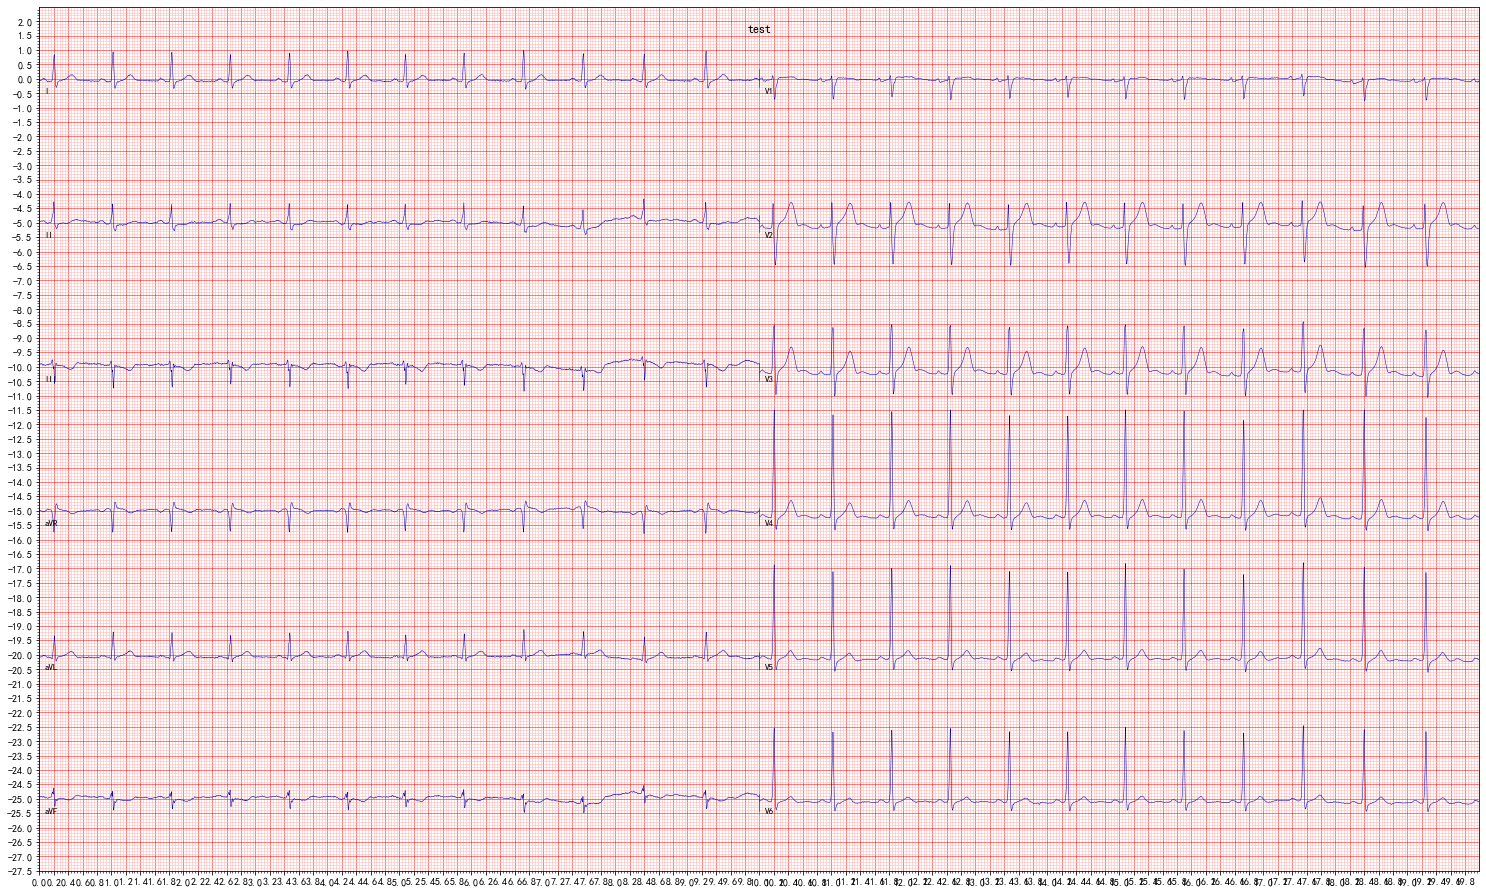

In [19]:
ECG,label = test_Dataset.__getitem__(33)
#inf,path = train_Dataset.get_basic_inf(55)
ecg_plot.plot(ECG*3.5, sample_rate = 500, title = "test",row_height= 10,show_grid=True,show_separate_line=True)
label

In [20]:
BATCH_SIZE = 150

FOLDS = 1
EPOCHS = 5000  
PATIENCE = 500
LR = 0.01

In [21]:
torch.cuda.empty_cache()# 清空显卡cuda
# NET = [
#     Net.channels_branch_CNN(True,res = True,se = True,Dropout_rate = 0.25)
# ]
# NET = [Net.channels_branch_CNN(True,res = True,se = True,Dropout_rate = 0.25) ] # type: ignore
# NET = [Net.MLBFNet_GUR(True,res = True,se = True,Dropout_rate = 0.25) ] # type: ignore
# NET = [se_inception_resnet_v2.SE_InceptionResnetV2(num_classes=2,in_chans=12) ] # type: ignore
# NET = [relat_abs_Net.MLBFNet_GUR() ] 
NET = [Net.MLBFNet_GUR(True,res = True,se = True,Dropout_rate = 0.1) ] # type: ignore

In [22]:
from torch.utils.tensorboard import SummaryWriter
os.makedirs(model_path, exist_ok=True)
writer = SummaryWriter(log_path)
# writer.add_graph(NET[0], torch.zeros((1,12,5000)))  #模型及模型输入数据
torch.cuda.empty_cache()# 清空显卡cuda

In [23]:
import torch.nn.functional as F

def linear_combination(x, y, epsilon): 
    return epsilon*x + (1-epsilon)*y
def reduce_loss(loss, reduction='mean'):
    return loss.mean() if reduction=='mean' else loss.sum() if reduction=='sum' else loss


class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, epsilon:float=0.1, reduction='mean'):
        super().__init__()
        self.epsilon = epsilon
        self.reduction = reduction
    
    def forward(self, preds, target):
        n = preds.size()[-1]
        log_preds = F.log_softmax(preds, dim=-1)
        loss = reduce_loss(-log_preds.sum(dim=-1), self.reduction)
        nll = F.nll_loss(log_preds, target, reduction=self.reduction)
        return linear_combination(loss/n, nll, self.epsilon)


In [24]:
class GCELoss(nn.Module):
    def __init__(self, num_classes=2, q=0.7):
        super(GCELoss, self).__init__()
        self.q = q
        self.num_classes = num_classes

    def forward(self, pred, labels):
        pred = torch.nn.functional.softmax(pred, dim=1)
        pred = torch.clamp(pred, min=1e-4, max=1.0)
        label_one_hot = torch.nn.functional.one_hot(labels, self.num_classes).float().to(pred.device)
        loss = (1. - torch.pow(torch.sum(label_one_hot * pred, dim=1), self.q)) / self.q
        return loss.mean()

In [25]:
import math
for fold in range(FOLDS):
    #每个人fold都重新抽取
    NET[fold].to(DEVICE)
    valid_list,train_list,addition_train_list = data.__get_VT_file_list__(0.9,True,'外科')  # type: ignore
    valid_Dataset = ecg_get_data.ECG_Dataset(ECG_root,valid_list,EcgChannles_num,EcgLength_num)
    # train_Dataset = ecg_get_data.ECG_Dataset(ECG_root,train_list,EcgChannles_num,EcgLength_num,ECG_root,addition_train_list)
    
    # train_dataloader = Data.DataLoader(dataset=train_Dataset, batch_size=BATCH_SIZE, shuffle=True,num_workers=16,pin_memory=True)
    valid_dataloader = Data.DataLoader(dataset=valid_Dataset, batch_size=BATCH_SIZE, shuffle=True,num_workers=16,pin_memory=True)
    test_dataloader = Data.DataLoader(dataset=test_Dataset, batch_size=BATCH_SIZE, shuffle=True,num_workers=16,pin_memory=True)
    early_stopping = EarlyStopping(PATIENCE, verbose=True, model_path=model_path, delta=0, positive=False)
    optimizer  = torch.optim.Adam(NET[fold].parameters(), lr=LR,weight_decay=1e-2)  
    
    warm_up_iter = 10
    T_max = 200	# 周期
    lr_max = 1e-3	# 最大值
    lr_min = 1e-5	# 最小值
    lambda0 = lambda cur_iter: lr_min if  cur_iter < warm_up_iter else \
        (lr_min + 0.5*(lr_max-lr_min)*(1.0+math.cos( (cur_iter-warm_up_iter)/(T_max-warm_up_iter)*math.pi)))/0.01
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda0)
    # criterion = torch.nn.CrossEntropyLoss()   
    train_HTN_list = list(filter(lambda x: x.find('_HTN.') >= 0, train_list))  # type: ignore
    candidate_NHTN_list = list(filter(lambda x: x.find('_NHTN.') >= 0, train_list)) + addition_train_list # type: ignore
    criterion = LabelSmoothingCrossEntropy()
    best_test_F1 = 0
    for epoch in range(1,EPOCHS):
        time_all=0
        train_list = data.pair_HTN_by_list_(train_HTN_list,candidate_NHTN_list,5)
        train_Dataset = ecg_get_data.ECG_Dataset(ECG_root,train_list,EcgChannles_num,EcgLength_num,shadow_npy_folder=ECG_root,shadow_npy_files_list=addition_train_list)
        train_dataloader = Data.DataLoader(dataset=train_Dataset, batch_size=BATCH_SIZE, shuffle=True,num_workers=4,pin_memory=True) 
        start_time = time.time()
        y_true,y_pred,train_loss,train_acc = train_model(train_dataloader, NET[fold], criterion, optimizer,DEVICE) # type: ignore # 训练模型
        time_all = time.time()-start_time
        F1_score_train =f1_score(y_true, y_pred, average='macro')#F1分数
        C0 = confusion_matrix(y_true,y_pred)
        y_true,y_pred,validate_loss,validate_acc = eval_model(valid_dataloader,criterion,NET[fold],DEVICE) # 验证模型
        F1_score_valid =f1_score(y_true, y_pred, average='macro')#F1分数
        C1 = confusion_matrix(y_true,y_pred)
        y_true,y_pred,test_loss,test_acc = eval_model(test_dataloader,criterion,NET[fold],DEVICE) # 验证模型
        F1_score_test =f1_score(y_true, y_pred, average='macro')#F1分数
        C2 = confusion_matrix(y_true,y_pred)

        # writer.add_scalars(main_tag=str(fold)+'_Loss',tag_scalar_dict={'train': train_loss,'validate': validate_loss},global_step=epoch)
        # writer.add_scalars(main_tag=str(fold)+'_Accuracy',tag_scalar_dict={'train': train_acc,'validate': validate_acc},global_step=epoch)
        # writer.add_scalars(main_tag=str(fold)+'_LearningRate',tag_scalar_dict={'LR': optimizer.state_dict()['param_groups'][0]['lr']},global_step=epoch)
        # writer.add_scalars(main_tag=str(fold)+'_F1_score',tag_scalar_dict={'train':F1_score_train,'validate': F1_score_valid},global_step=epoch)
        writer.add_scalars(main_tag=str(fold)+'_Loss',tag_scalar_dict={'train': train_loss,'validate': validate_loss,'test':test_loss},global_step=epoch)
        writer.add_scalars(main_tag=str(fold)+'_Accuracy',tag_scalar_dict={'train': train_acc,'validate': validate_acc,'test':test_acc},global_step=epoch)
        writer.add_scalars(main_tag=str(fold)+'_LearningRate',tag_scalar_dict={'LR': optimizer.state_dict()['param_groups'][0]['lr']},global_step=epoch)
        writer.add_scalars(main_tag=str(fold)+'_F1_score',tag_scalar_dict={'train':F1_score_train,'validate': F1_score_valid,'test':F1_score_test},global_step=epoch)        
        print('- Epoch: %d - Train_loss: %.5f - Train_acc: %.5f - F1 score: %.5f - Val_loss: %.5f - Val_acc: %.5f - F1 score: %.5f - T_Time: %.5f' %(epoch,train_loss,train_acc,F1_score_train,validate_loss,validate_acc,F1_score_valid,time_all))
        print('当前学习率：%.8f' %optimizer.state_dict()['param_groups'][0]['lr'])
        print('train:\n',C0)
        print('validate:\n',C1)
        print('test:\n',C2)
        
        if(F1_score_test>best_test_F1):
            best_test_F1 = F1_score_test
            torch.save(NET[fold].state_dict(), model_path+'/parameter_best_test_' + str(fold) + '.pt')
        
        scheduler.step() # 学习率迭代
        #是否满足早停法条件
        if(early_stopping(validate_loss,NET[fold],fold)):
            print("Early stopping")
            break

    print('Fold %d Training Finished' %(fold+1))
    torch.cuda.empty_cache()# 清空显卡cuda
print('Training Finished')

	
 orginal   fliter department&age
  44111       7362   
	
 orginal   fliter duplicated
   998        866    
	
 orginal   fliter duplicated
   7362       6326   
lack sample like : Pandas(Index=702, num=22362, name='潘世明', years=97, gender='男', department='干部保健一科一区', diagnose='高血压病3级（极高危）', ID='807057', date='2020-04-15 04:21:14', ECG_path='20-22362_97-1_HTN.npy')
lack sample like : Pandas(Index=247, num=369, name='李文友', years=95, gender='男', department='', diagnose='', ID='', date='', ECG_path='00-369_95-1_HTN.npy')
	
       HTN  NHTN 
train  779   779 
valid  87    87  
 add    0   5460 
npys:{%d} 174
lack sample like : Pandas(Index=702, num=22362, name='潘世明', years=97, gender='男', department='干部保健一科一区', diagnose='高血压病3级（极高危）', ID='807057', date='2020-04-15 04:21:14', ECG_path='20-22362_97-1_HTN.npy')
lack sample like : Pandas(Index=606, num=13411, name='李如绥', years=95, gender='男', department='干部保健二科一区', diagnose='高血压病3级（极高危）', ID='297125', date='2020-10-11 16:33:39', ECG_path='20-13